# Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed

np.random.seed(1)
tf.random.set_seed(1)

### Utils

In [3]:
# Create sequences for the LSTM
TIME_STEPS = 50
def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [10]:
base = '../'
base_dataset = 'datasets/custom/'
base_out = 'plots/'
users_list = ['USER1', 'USER2', 'USER3', 'USER4']
colnames = ['heavy',
            'moderate',
            'light',
            'rest',
            'overall_score',
            'resting_heart_rate']
col_color = {'heavy':'g',
            'moderate':'r',
            'light':'c',
            'rest':'m',
            'overall_score':'y',
            'resting_heart_rate':'orange'}

# LSTM

/opt/miniconda3/lib/python3.12/site-packages/keras/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 50, 1)          │           129 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

ModuleNotFoundError: No module named 'keras._tf_keras'

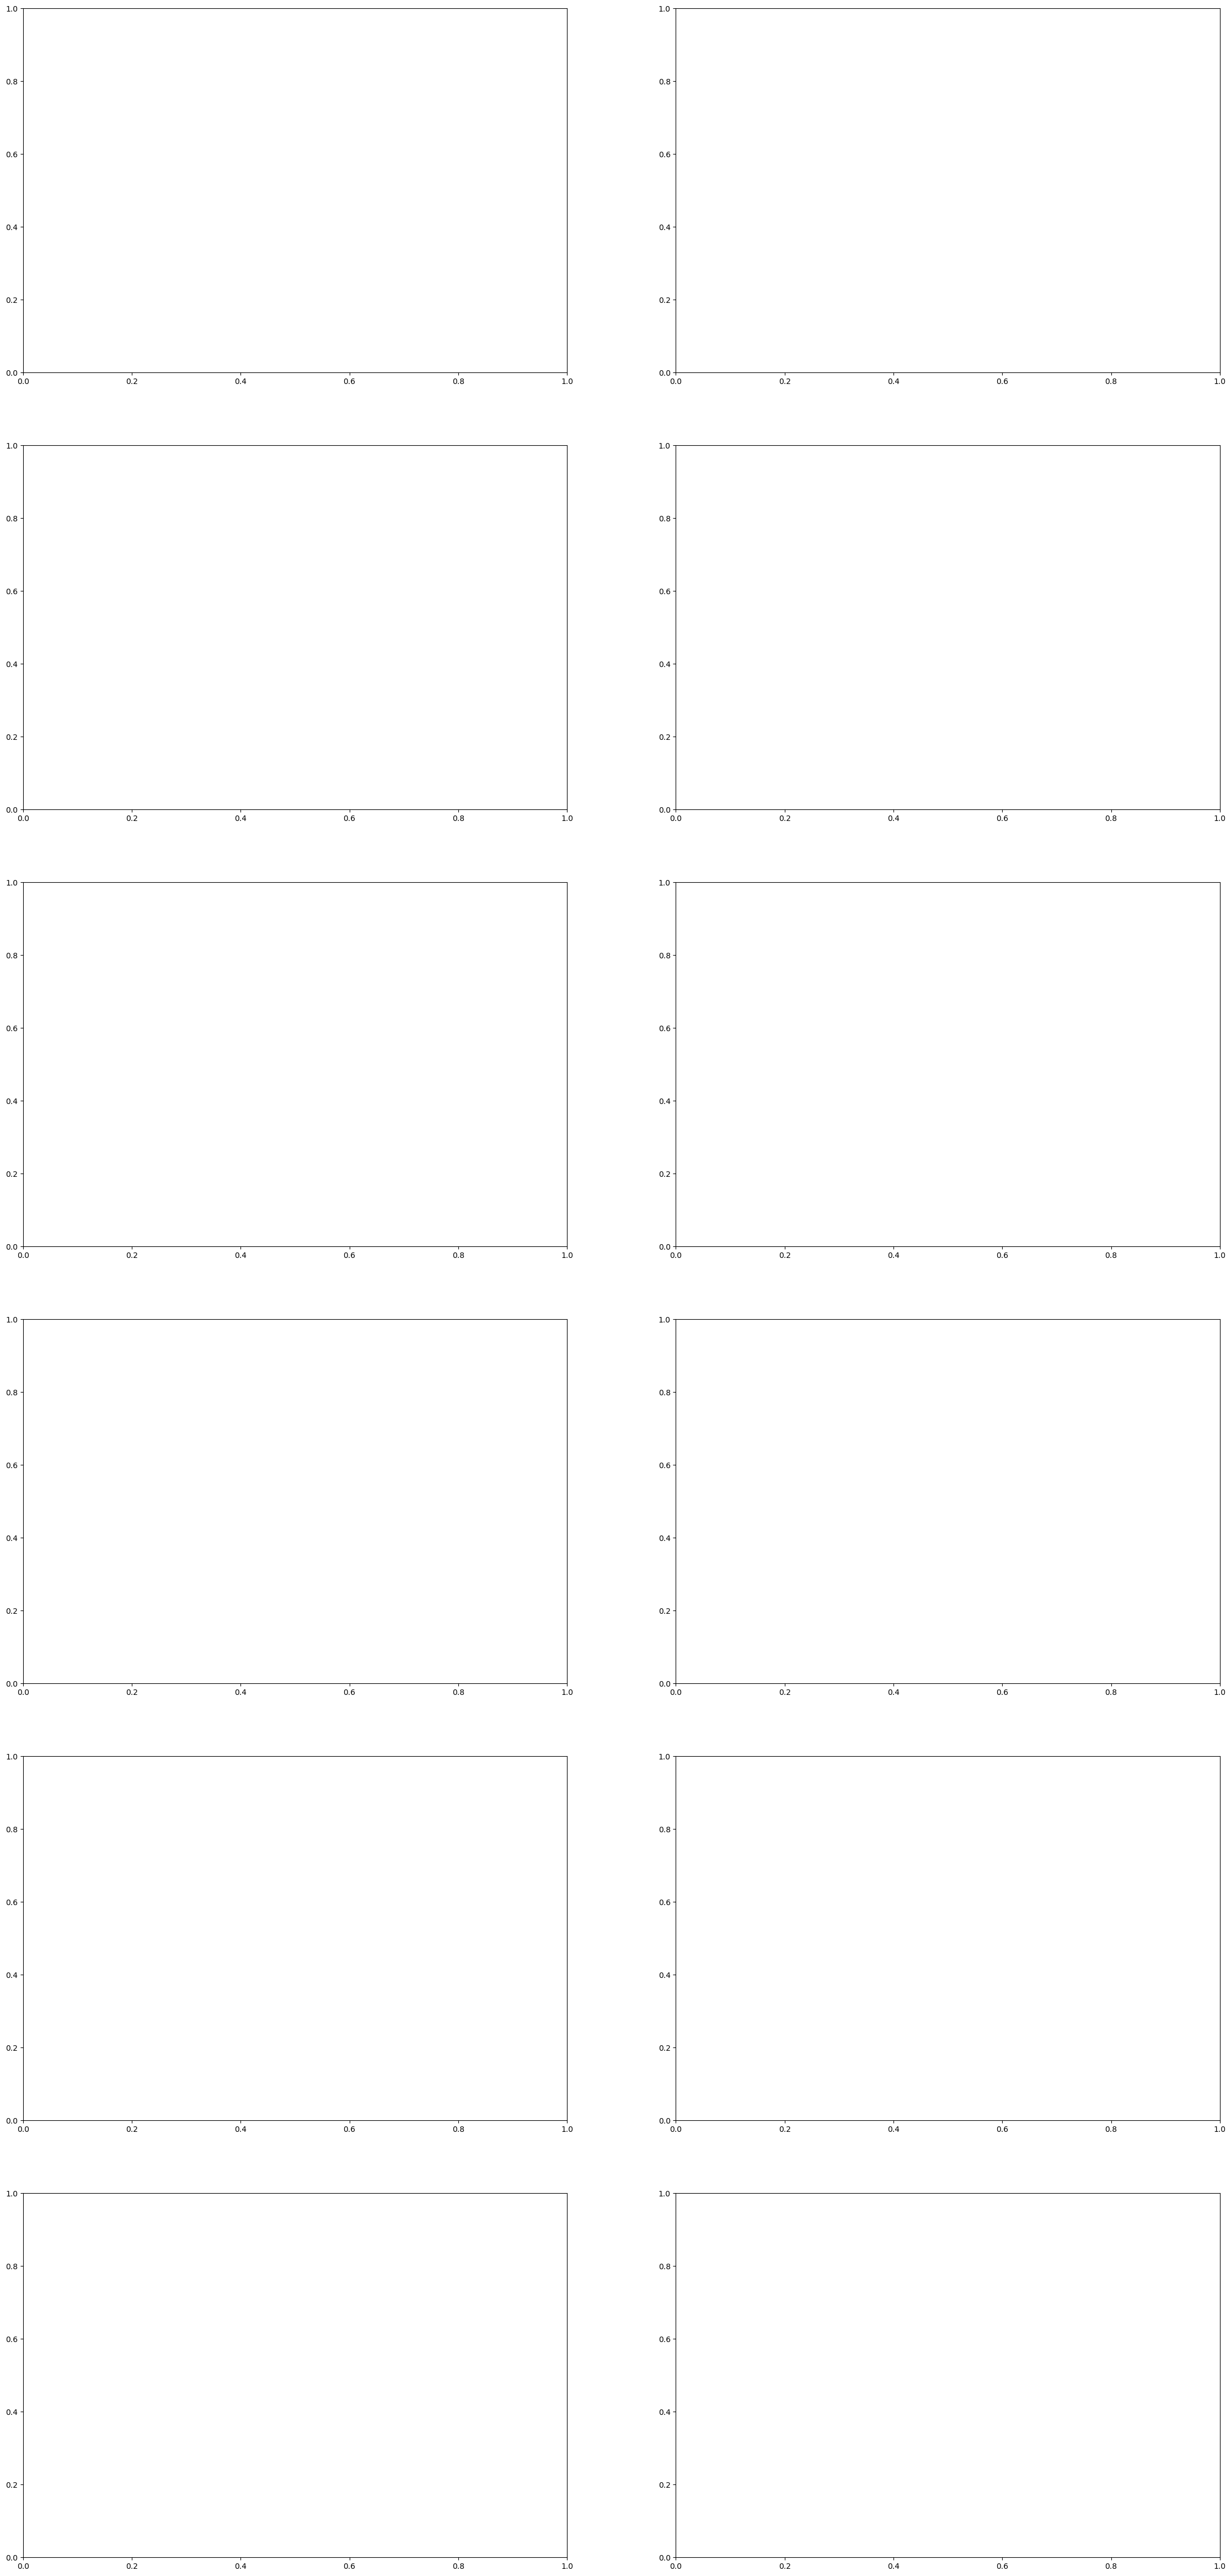

In [12]:
total_scores_df = dict()
users = list()

for user in users_list:
  fig_plt,ax = plt.subplots(len(colnames),2,figsize=(28, 60))
  r=0 

  users.append(user)
  df_anomalies = pd.DataFrame()
  for col_name in colnames:
    # Load and preprocess the data
    df = pd.read_csv(base+base_dataset+user+'/activity.csv')
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    # Standardize the overall_score column
    scaler = StandardScaler()
    df[col_name] = scaler.fit_transform(df[[col_name]])

    X, y = create_sequences(df[[col_name]], df[col_name])
    #print(f'Data shape: {X.shape}')

    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(128, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dropout(rate=0.2))
    model.add(RepeatVector(X.shape[1]))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(rate=0.2))
    model.add(TimeDistributed(Dense(X.shape[2])))
    model.compile(optimizer='adam', loss='mae')
    model.summary()

    # Train the model
    history = model.fit(X, y, epochs=100, batch_size=32, validation_split=0.1,
                        callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')], shuffle=False, verbose = 0)

    # Compute reconstruction error
    X_pred = model.predict(X, verbose=0)
    mae_loss = np.mean(np.abs(X_pred - X), axis=1)
    threshold = np.percentile(mae_loss, 80)

    # Detect anomalies
    score_df = pd.DataFrame(df[TIME_STEPS:])
    score_df['loss'] = mae_loss
    score_df['threshold'] = threshold
    score_df[f'anomaly'] = score_df['loss'] > score_df['threshold']

    if len(df_anomalies) == 0:
      df_anomalies['timestamp'] = score_df.timestamp
    df_anomalies[col_name] = score_df['anomaly']

    # Plot test loss vs threshold
    ax[r][0].plot(score_df['timestamp'], score_df['loss'], label='Test loss')
    ax[r][0].plot(score_df['timestamp'], score_df['threshold'], label='Threshold')
    ax[r][0].set_title(f'Test loss vs. Threshold - COL: {col_name}')

    # Visualize anomalies
    anomalies = score_df[score_df[f'anomaly'] == True]

    ax[r][1].plot(score_df['timestamp'], scaler.inverse_transform(score_df[col_name].values.reshape(-1, 1)).flatten(), label='Score')
    ax[r][1].scatter(anomalies['timestamp'], scaler.inverse_transform(anomalies[col_name].values.reshape(-1, 1)).flatten(), label='Anomaly', color='red')

    # Set axis labels and title
    ax[r][1].set_xlabel('Date')
    ax[r][1].set_ylabel(col_name)
    ax[r][1].set_title('Detected Anomalies')

    for x in range(len(colnames)):
      for idx, row in score_df.iterrows():
        if row.anomaly:
          width = 4
        else:
          width = 1

        if idx == score_df.index.values[-1]:
          ax[x][1].plot([score_df.loc[idx-1].timestamp, row.timestamp], [0-5*r,0-5*r], color=col_color[col_name], linewidth = width, label = col_name)
        else:
          ax[x][1].plot([row.timestamp, score_df.loc[idx+1].timestamp], [0-5*r,0-5*r], color=col_color[col_name], linewidth = width, label = col_name)

    r+=1

    total_scores_df[user] = df_anomalies

  for c in [0,1]:
    for r in range(len(colnames)):
      ax[r][c].legend(handles=[
                  plt.Line2D([], [], color='g', label='heavy'),
                  plt.Line2D([], [], color='r', label='moderate'),
                  plt.Line2D([], [], color='c', label='light'),
                  plt.Line2D([], [], color='m', label='rest'),
                  plt.Line2D([], [], color='y', label='overall_score'),
                  plt.Line2D([], [], color='orange', label='resting_heart_rate'),
              ])

  fig_plt.suptitle(f'USER: {user}')
  #plt.savefig(f'{base}{base_out}{user}_80thresh.pdf',bbox_inches='tight', )
  plt.show()


# Anomalies plots


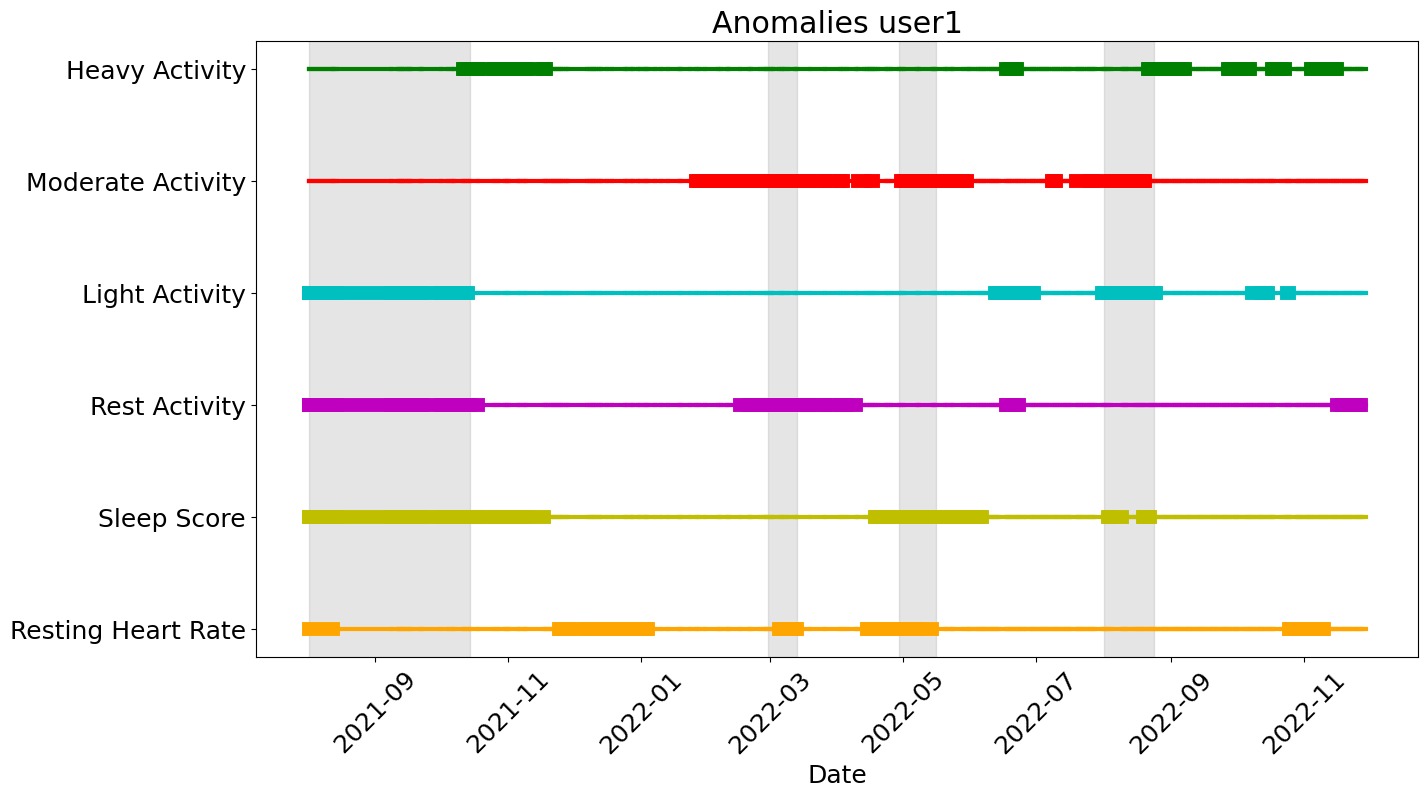

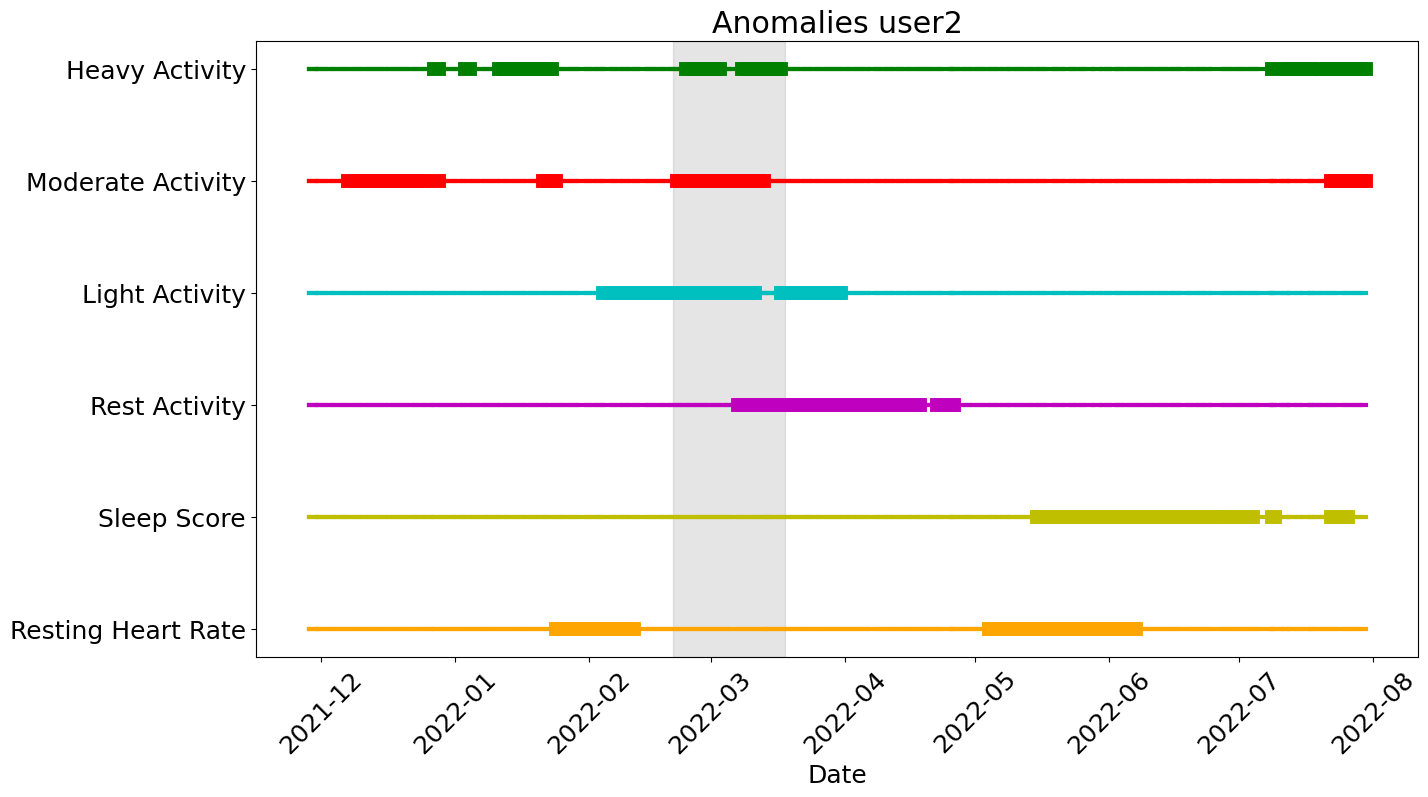

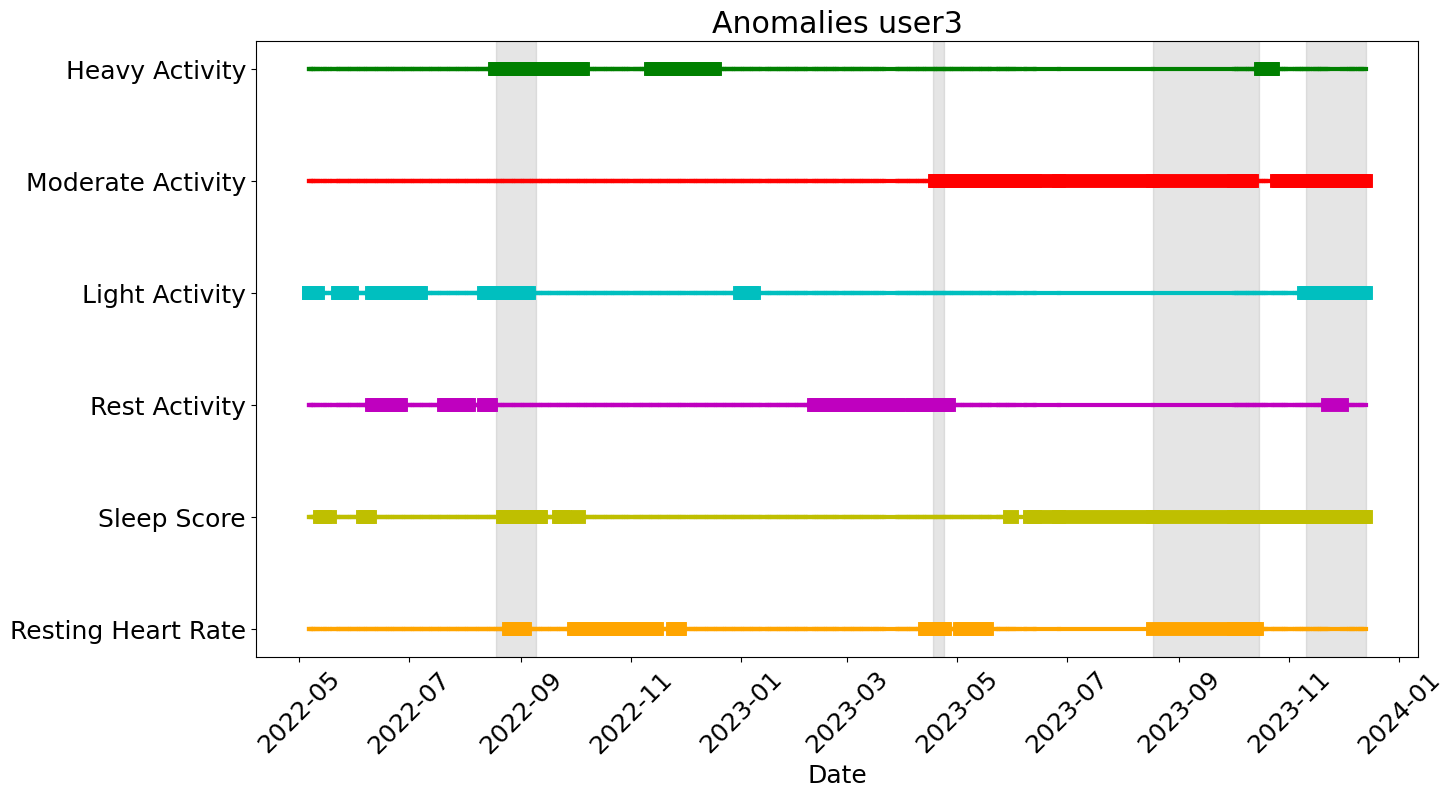

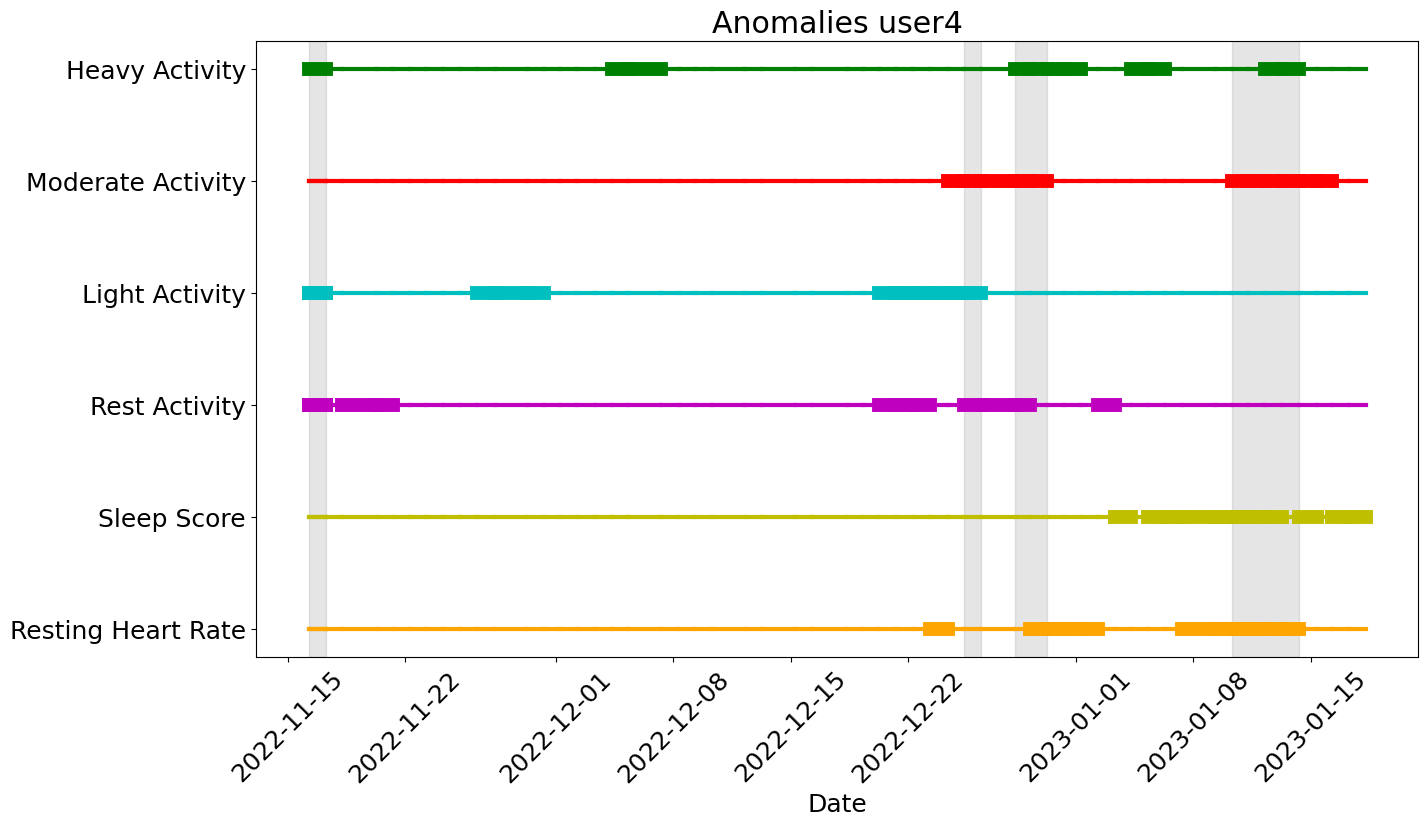

In [15]:
for user in users:
  fig,ax = plt.subplots(1,figsize=(15,8))
  plt.rcParams.update({'font.size': 18})
  ax.set_xlabel('Date')

  df_anomalies = total_scores_df[user]

  for x in range(len(colnames)):

    for idx, row in df_anomalies.iterrows():
      if row[colnames[x]]:
        width = 10
      else:
        width = 3

      if idx == df_anomalies.index.values[-1]:
        ax.plot([df_anomalies.loc[idx-1].timestamp, df_anomalies.loc[idx].timestamp], [0-1*x,0-1*x], color=col_color[colnames[x]], linewidth = width, label = col_name)
      else:
        ax.plot([df_anomalies.loc[idx].timestamp, df_anomalies.loc[idx+1].timestamp], [0-1*x,0-1*x], color=col_color[colnames[x]], linewidth = width, label = col_name)

  ax.set_yticks((-5,-4,-3,-2,-1,0),('Resting Heart Rate','Sleep Score', 'Rest Activity', 'Light Activity', 'Moderate Activity', 'Heavy Activity') )
  ax.set_title(f'Anomalies {user}')

  if user == 'user1':
    ax.axvspan(df_anomalies.loc[335].timestamp, df_anomalies.loc[315].timestamp, color='gray', alpha = 0.2)
    ax.axvspan(df_anomalies.loc[255].timestamp, df_anomalies.loc[247].timestamp, color='gray', alpha = 0.2)
    ax.axvspan(df_anomalies.loc[229].timestamp, df_anomalies.loc[222].timestamp, color='gray', alpha = 0.2)
    ax.axvspan(df_anomalies.loc[160].timestamp, df_anomalies.loc[142].timestamp, color='gray', alpha = 0.2)
  elif user == 'user2':
    ax.axvspan(df_anomalies.loc[200].timestamp, df_anomalies.loc[174].timestamp, color='gray', alpha = 0.2)
  elif user == 'user3':
    ax.axvspan(df_anomalies.loc[72].timestamp, df_anomalies.loc[50].timestamp, color='gray', alpha = 0.2)
    ax.axvspan(df_anomalies.loc[110].timestamp, df_anomalies.loc[95].timestamp, color='gray', alpha = 0.2)
    ax.axvspan(df_anomalies.loc[163].timestamp, df_anomalies.loc[157].timestamp, color='gray', alpha = 0.2)
    ax.axvspan(df_anomalies.loc[392].timestamp, df_anomalies.loc[370].timestamp, color='gray', alpha = 0.2)

  elif user == 'user4':
    ax.axvspan(df_anomalies.loc[58].timestamp, df_anomalies.loc[54].timestamp, color='gray', alpha = 0.2)
    ax.axvspan(df_anomalies.loc[70].timestamp, df_anomalies.loc[68].timestamp, color='gray', alpha = 0.2)
    ax.axvspan(df_anomalies.loc[72].timestamp, df_anomalies.loc[71].timestamp, color='gray', alpha = 0.2)
    ax.axvspan(df_anomalies.loc[105].timestamp, df_anomalies.loc[104].timestamp, color='gray', alpha = 0.2)

  ax.tick_params(axis='x', labelrotation=45)

  plt.savefig(f'{base}{base_out}{user}_anomalies.pdf',bbox_inches='tight', )
  plt.show()